In [1]:
import pandas as pd
from scipy import stats
from core.analysis import *

<Figure size 432x288 with 0 Axes>

## Data Prep

In [2]:
db = access_db()


In [3]:
results, corrs = get_results_users(db)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [7]:
failed_rep = set(corrs[corrs['Group Consistency'] < 0.4]['userID'])
failed_shared = set(corrs[corrs['Self Consistency'] < 0.2]['userID'])

Participants who failed under both exclusion criteria.

In [9]:
len(failed_rep.intersection(failed_shared))

10

## Exclusion Criteria

In [4]:
corrs.iloc[:104][["timeTaken", 'changes']].apply([np.mean, np.std]) #104th participant took 20 hours

,timeTaken,changes
mean,900.411260,8.519231
std,926.998981,6.116952


In [5]:
len(corrs[corrs['timeTaken'] < 60 * 30])

99

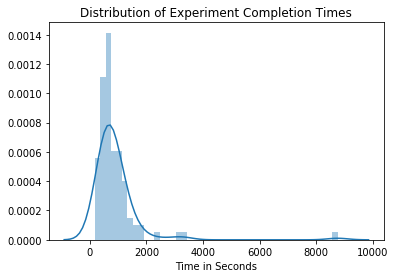

In [6]:
sns.distplot(corrs.iloc[:104]['timeTaken'])
plt.xlabel("Time in Seconds")
plt.title("Distribution of Experiment Completion Times")
plt.savefig("../../results/figures/expt_times.png")

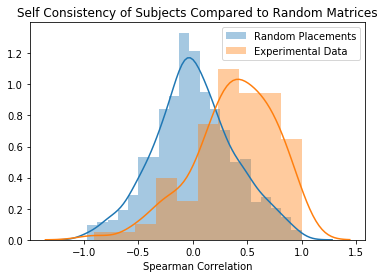

In [11]:
random_self = simulate_self_correlation(1000, db)
sns.distplot(random_self, label = "Random Placements")
sns.distplot(corrs['Self Consistency'], label = "Experimental Data")
plt.title("Self Consistency of Subjects Compared to Random Matrices")
plt.xlabel("Spearman Correlation")
plt.legend()
plt.savefig("../../results/figures/self_consistency.png")

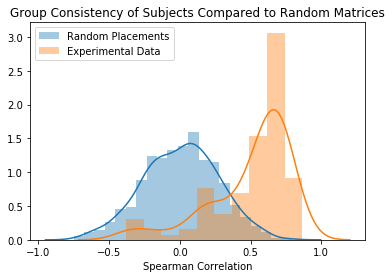

In [17]:
shared_results = results[results['trialType'] == 'shared']
random_group = [random_vs_all(shared_results) for _ in range(1000)]
sns.distplot(random_group, label = "Random Placements")
sns.distplot(corrs['Group Consistency'], label = "Experimental Data")
plt.title("Group Consistency of Subjects Compared to Random Matrices")
plt.xlabel("Spearman Correlation")
plt.legend()
plt.savefig("../../results/figures/group_consistency.png")

In [12]:
len(corrs[corrs['Self Consistency'] > 0.2])

77

In [13]:
len(corrs[corrs['Group Consistency'] > 0.4])

78

Exclusion criteria: Self below 0.2 or Group below 0.4

## MDS

In [ ]:
with open('../data/stimuli.json') as f:
    stim_data = json.load(f)

In [9]:
plt.rcParams["font.family"] = "Times New Roman"


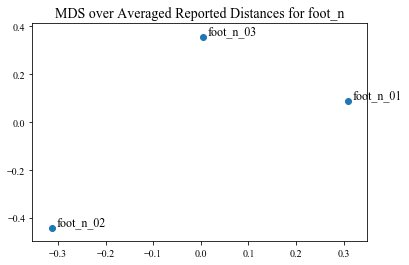

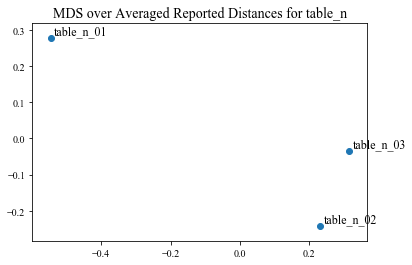

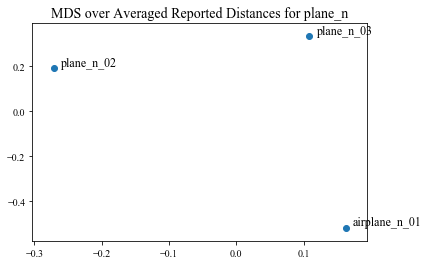

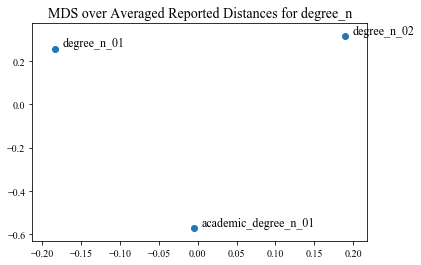

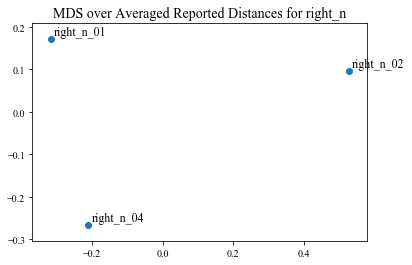

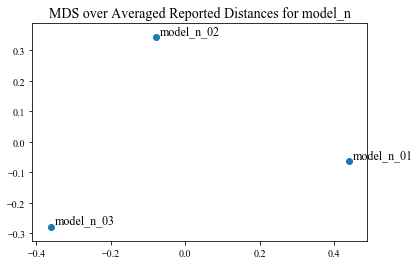

In [11]:
#incl_users = exclusion_criteria(corrs)
plot_all_mds(results, incl_users, 'shared', v)

In [12]:
results[results['userID'].isin(incl_users)].to_csv("../data/approved_expt_results.csv")

## Test Trials

Number of trials we got for each test/repeat word

In [73]:
test_data = results[(results['userID'].isin(incl_users)) & (results['trialType'].isin(['test', 'repeat']))]
lemma_counts = test_data['lemma'].value_counts()
lemma_counts / [get_num_senses(l, stim_data) for l in lemma_counts.index]

world_n       47.0
life_n        38.0
cover_v       39.0
time_n        38.0
consider_v    37.0
lead_v        26.0
case_n        40.0
death_n       40.0
face_n        38.0
indicate_v    37.0
raise_v       37.0
point_n       29.0
way_n         29.0
area_n        46.0
door_n        45.0
ask_v         41.0
drive_v       30.0
put_v         40.0
heart_n       39.0
begin_v       38.0
school_n      38.0
produce_v     37.0
glass_n       35.0
man_n         26.0
book_n        30.0
light_n       30.0
Name: lemma, dtype: float64

## Tagging Homonymous Senses

In [43]:
df = get_tagged_distances(results, incl_users, stim_data)
df.to_csv("../data/sense_pair_distances.csv", index = False)

Counting polysemous and homonymous relations

In [71]:
df['relation_type'].value_counts()

polysemous    5584
homonymous     940
Name: relation_type, dtype: int64

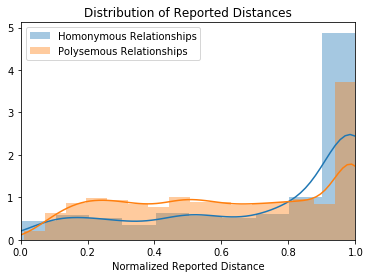

In [72]:
hom_dist = df[df['relation_type'] == 'homonymous']['dist']
pol_dist = df[df['relation_type'] == 'polysemous']['dist']
sns.distplot(hom_dist, label = 'Homonymous Relationships')
sns.distplot(pol_dist, label = 'Polysemous Relationships')
plt.title("Distribution of Reported Distances")
plt.xlim(0, 1)
plt.xlabel("Normalized Reported Distance")
plt.legend()
plt.savefig("../../results/figures/expt_ph_dist.png")

Because this distribution has a strong left tail, the medians give us a better idea of the "center" of the distribution than the means, and we need to use a non parametric test (Mann-Whitney).

In [73]:
np.median(hom_dist)

0.8808745640426944

In [74]:
np.median(pol_dist)

0.6305223665981379

In [76]:
stats.mannwhitneyu(hom_dist, pol_dist)

MannwhitneyuResult(statistic=1959176.5, pvalue=3.518772011507835e-36)

## Sampling Test items-sized Number of Judgments from Shared Stimuli

In [10]:
results = pd.read_csv('../data/approved_expt_results.csv')
incl_users = results['userID'].unique()
results.head()

,Unnamed: 0,trialID,userID,trialIndex,trialType,prevChanged,lemma,sense,x,y
0,206,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,bank_n_01,173.0,360.0
1,207,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,bank_n_05,614.0,362.0
2,208,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,depository_financial_institution_n_01,499.0,368.0
3,209,-M3pVmug0DJj2iajKInK,-M3pVTw9ili6muvdZKg4,2,training,0,bass_n,bass_n_03,241.0,402.0
4,210,-M3pVmug0DJj2iajKInK,-M3pVTw9ili6muvdZKg4,2,training,0,bass_n,bass_n_04,723.0,324.0


In [11]:
test_results = results[results['trialType'] == 'test']
users = results['userID'].unique()
test_matrices = {w: {} for w in test_results['lemma'].unique()}

for w in test_matrices.keys():
    test_matrices[w] = mean_distance_mtx(results, w, 'test', users, normalize = True)

In [12]:
responses_per_type = int(np.round(np.mean(test_results.groupby('lemma').userID.agg(lambda s:
                                                                                    len(np.unique(s)))), 0))

In [14]:
shared_results = results[results['trialType'] == 'shared']
shared_lst = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']


In [59]:
shared_resampled = []
for l in shared_lst:
    shared_for_type = shared_results[shared_results['lemma'] == l]
    user_sample = np.random.choice(users, int(responses_per_type), replace = True)
    i = 0
    for u in user_sample:
        user_data = shared_for_type[shared_for_type['userID'] == u]
        user_data['userID'] = i
        shared_resampled.append(user_data)
        i += 1

downsampled_shared = pd.concat(shared_resampled)

downsampled_shared_matrices = {w: {} for w in shared_lst}

for w in shared_matrices.keys():
    downsampled_shared_matrices[w] = mean_distance_mtx(downsampled_shared, w, 'shared', downsampled_shared['userID'].unique(),
                                           normalize = True)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'shared_matrices' is not defined

In [15]:
from core.metrics import cosine_sim_mtx

In [17]:
target_words = pd.concat([test_results, shared_results])['lemma'].unique()
bert_matrices = {w: {} for w in target_words}

for w in target_words:
    word, pos = w.split('_')
    bert_matrices[w] = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)], use_masc = False,
              normalize = True)[0]

In [27]:
all_bert_cs = [bert_matrices[w] for w in bert_matrices.keys()]
test_bert_cs = [bert_matrices[w] for w in bert_matrices.keys() if w not in shared_lst]
test_human_avg = [test_matrices[w] for w in test_matrices.keys()]

In [19]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


In [44]:
r_est = []
p_est = []
r_test = []
random = []
user_sample = np.random.choice(users, int(responses_per_type), replace = True)
for _ in tqdm(list(range(1000))):    
    shared_resampled = []

    for l in shared_lst:
        shared_for_type = shared_results[shared_results['lemma'] == l]
        i = 0
        for u in user_sample:
            user_data = shared_for_type[shared_for_type['userID'] == u]
            user_data['userID'] = i
            shared_resampled.append(user_data)
            i += 1

    downsampled_shared = pd.concat(shared_resampled)

    downsampled_shared_matrices = {w: {} for w in shared_lst}

    for w in downsampled_shared_matrices.keys():
        downsampled_shared_matrices[w] = mean_distance_mtx(downsampled_shared, w, 'shared', downsampled_shared['userID'].unique(),
                                               normalize = True)

    human_matrices = dict(list(test_matrices.items()) + list(downsampled_shared_matrices.items()))
    all_human_avg = [human_matrices[w] for w in human_matrices.keys()]
    test_human_avg = [test_matrices[w] for w in test_matrices.keys()]
    bert_human_all, human, bert = mtx_correlation(all_human_avg, all_bert_cs, return_ut = True)
    random_avg = []
    for w in human_matrices.keys():
        avg_dim = np.mean([create_random_symmetric_mtx(get_num_senses(w, db)) for _ in range(responses_per_type)], axis = 0)
        random_avg.append(avg_dim / np.max(avg_dim))
    random_placement = mtx_correlation(random_avg, all_human_avg, method = 'spearman')[0]
    r_est.append(bert_human_all[0])
    p_est.append(bert_human_all[1])
    random.append(random_placement)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
np.mean(r_est)

0.562372959765085

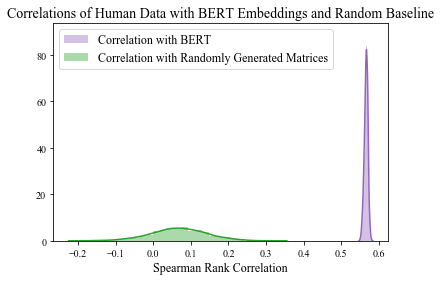

In [72]:
sns.distplot(r_est, label = 'Correlation with BERT', color = 'C4')
sns.distplot(random, label = "Correlation with Randomly Generated Matrices", color = 'C2')
plt.legend(fontsize = 12)
plt.xlabel("Spearman Rank Correlation", fontsize = 12)
plt.title("Correlations of Human Data with BERT Embeddings and Random Baseline", fontsize = 14)
plt.savefig('../../results/figures/random_all_sampled.png')

In [184]:
create_random_symmetric_mtx()

array([[0.        , 0.91484059, 0.17823143],
       [0.91484059, 0.        , 1.        ],
       [0.17823143, 1.        , 0.        ]])

In [46]:
print("95% Confidence Interval for Correlation", (np.percentile(r_est, 2.5), np.percentile(r_est, 97.5)))

95% Confidence Interval for Correlation (0.562372959765085, 0.562372959765085)


In [47]:
np.mean(random)

0.0706151172074547

In [48]:
print("95% Confidence Interval for Random Baseline", (np.percentile(random, 2.5), np.percentile(random, 97.5)))

95% Confidence Interval for Random Baseline (-0.07655213472248519, 0.2084203451029004)


In [29]:
mtx_correlation(test_human_avg, test_bert_cs, method = 'spearman')

SpearmanrResult(correlation=0.5546943395771994, pvalue=3.4944895519038967e-15)

## Sense Definitions for Presentation/Paper

Getting tables with information about the WordNet senses and their definitions for types used in the figures. Pandas dataframes can be converted to Latex tables, so we get the words we need, filter them based on the figure, and then convert to Latex.

In [51]:
all_test_defs = display_sense_definitions(results, 'test')
all_test_defs['Sense'] = all_test_defs['Sense'].apply(lambda s: s.replace('_', '.'))
all_test_defs['Type'] = all_test_defs['Type'].apply(lambda s: s.replace('_', '.'))


In [58]:
all_test_defs[all_test_defs['Type'] == 'area.n'].to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} &      Sense &    Type &                                                                                                                                             Definition \\\\\n\\midrule\n95 &  area.n.01 &  area.n &  a particular geographical region of indefinite boundary (usually serving some special purpose or distinguished by its people or culture or geography) \\\\\n96 &  area.n.02 &  area.n &                                                                                                                                     a subject of study \\\\\n97 &  area.n.03 &  area.n &                                                              a part of an animal that has a special function or is supplied by a given artery or nerve \\\\\n\\bottomrule\n\\end{tabular}\n'

In [37]:
fig_words = all_test_defs[all_test_defs['Type'].isin(['world_n', 'indicate_v', 'lead_v', 'life_n'])]

#fig_words.to_csv('../data/scatter_defns.csv', index = False)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
fig_words[fig_words['Type'] == 'raise.v'].to_latex(index = False)

'\\begin{tabular}{lll}\n\\toprule\n      Sense &     Type &                                    Definition \\\\\n\\midrule\n raise.v.01 &  raise.v &        raise the level or amount of something \\\\\n raise.v.02 &  raise.v &       raise from a lower to a higher position \\\\\n raise.v.03 &  raise.v &  cause to be heard or known; express or utter \\\\\n raise.v.04 &  raise.v &          collect funds for a specific purpose \\\\\n\\bottomrule\n\\end{tabular}\n'